# This notebook uses pytorch lightning & optuna & a Recurrent Attentive Neural Process for Sequential Data (RANPfSQ)

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

- similar to https://arxiv.org/abs/1910.09323

Results on *Smartmeter* prediction

|Model|val_loss|
|--|--| 
|ANP-RNN|-1.27|
|ANP-RNN_imp|-1.38|
|ANP|-1.3|
|ANP_impr|-1.2|
|NP|-1.3|

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL
from src.dict_logger import DictLogger

In [5]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [6]:
df_train, df_test = get_smartmeter_df()
data_train = SmartMeterDataSet(
            df_train, 24, 24
)
x, y = data_train[0]
x.shape, y.shape

((48, 17), (48, 1))

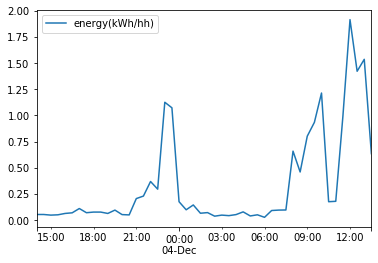

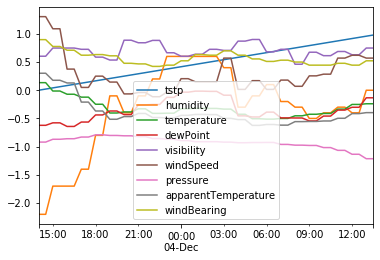

In [7]:
x_rows, y_rows = data_train.get_rows(10)
y_rows.plot()
x_rows.drop(columns=['month','day','week','minute','hour','dayofweek', 'future', 'holiday']).plot()

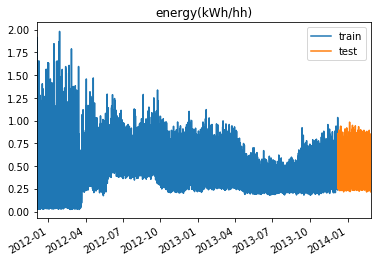

In [8]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Default params

In [9]:
default_params = {
    'attention_dropout': 0,
    'attention_layers': 2,
    'batchnorm': False,
    'det_enc_cross_attn_type': 'multihead',
    'det_enc_self_attn_type': 'uniform',
    'dropout': 0,
    'hidden_dim': 64,
    'latent_dim': 32,
    'latent_enc_self_attn_type': 'uniform',
    'learning_rate': 2e-4,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
    'n_latent_encoder_layers': 2,
    'use_deterministic_path': True,
    'use_lvar': True,
    'use_rnn': False,
    'use_self_attn': True,
    'use_lstm_de': False,
    'use_lstm_d': False,
    'use_lstm_le': False,
}

In [10]:
user_attrs = {
    'batch_size': 16,
    'grad_clip': 40,
    'max_nb_epochs': 20,
    'num_workers': 4,
    'target_length': 24,
    'vis_i': '670',
    'num_context': 24,
    'num_extra_target': 24,
    'min_std': 0.005,
    'num_heads': 8,
    'context_in_target': True,
    'x_dim': x.shape[-1],
    'y_dim': y.shape[-1]
} 
user_attrs

{'batch_size': 16,
 'grad_clip': 40,
 'max_nb_epochs': 20,
 'num_workers': 4,
 'target_length': 24,
 'vis_i': '670',
 'num_context': 24,
 'num_extra_target': 24,
 'min_std': 0.005,
 'num_heads': 8,
 'context_in_target': True,
 'x_dim': 17,
 'y_dim': 1}

# Train helpers

In [11]:
PERCENT_TEST_EXAMPLES = 0.5
# name = 'anp-rnn4' # study name

MODEL_DIR = Path('.')/ 'optuna_result'/ 'anp-rnn5_s'
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"now run `tensorboard --logdir {MODEL_DIR}")

now run `tensorboard --logdir optuna_result/anp-rnn5_s


In [12]:
from pytorch_lightning.callbacks import EarlyStopping

In [13]:
def main(trial, train=False, name='anp-rnn', optuna=False): 
    """Setup pytorch lightning train."""
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

    # The default logger in PyTorch Lightning writes to event files to be consumed by
    # TensorBoard. We create a simple logger instead that holds the log in memory so that the
    # final accuracy can be obtained after optimization. When using the default logger, the
    # final accuracy could be stored in an attribute of the `Trainer` instead.
    logger = DictLogger(MODEL_DIR, name=name, version=trial.number)
    
    if optuna:
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    else:
        early_stop_callback = EarlyStopping(
            monitor='val_loss',
            min_delta=0.00,
            patience=2,
            verbose=True,
            mode='min'
        )
    

    trainer = pl.Trainer(
        logger=logger,
        val_percent_check=PERCENT_TEST_EXAMPLES,
        gradient_clip_val=trial.user_attrs["grad_clip"],
        checkpoint_callback=checkpoint_callback,
        max_epochs=trial.user_attrs['max_nb_epochs'],
        gpus=-1 if torch.cuda.is_available() else None,
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    )
    model = LatentModelPL(dict(**trial.params, **trial.user_attrs))
    if train:
        trainer.fit(model)
    
    return model, trainer


def add_sugg(trial, name):
    """Add optuna suggestions and user attrs"""
    
    trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    trial.suggest_categorical("hidden_dim", [8*2**i for i in range(6)])
    trial.suggest_categorical("latent_dim", [8*2**i for i in range(6)])
    
    trial.suggest_int("attention_layers", 1, 4)
    trial.suggest_categorical("n_latent_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_det_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_decoder_layers", [1, 2, 4, 8])

    trial.suggest_categorical("dropout", [0, 0.2, 0.5])
    trial.suggest_categorical("attention_dropout", [0, 0.2, 0.5])

    trial.suggest_categorical(
        "latent_enc_self_attn_type", ['uniform', 'multihead', 'ptmultihead']
    )
    trial.suggest_categorical("det_enc_self_attn_type",  ['uniform', 'multihead', 'ptmultihead'])
    trial.suggest_categorical("det_enc_cross_attn_type", ['uniform', 'multihead', 'ptmultihead'])

    trial.suggest_categorical("batchnorm", [False, True])
    trial.suggest_categorical("use_self_attn", [False, True])
    trial.suggest_categorical("use_lvar", [False, True])
    trial.suggest_categorical("use_deterministic_path", [False, True])
    trial.suggest_categorical("use_rnn", [True, False])
    trial.suggest_categorical("use_lstm_le", [True, False])
    trial.suggest_categorical("use_lstm_de", [True, False])
    trial.suggest_categorical("use_lstm_d", [True, False])
    

    # non hyperparams, ones that we want to keep constant
    trial._user_attrs = user_attrs
    
    # For manual experiment we will start at -1 and deincr by 1
    versions = [int(s.stem.split('_')[-1]) for s in (MODEL_DIR / name).glob('version_*')] + [-1]
    trial.number = min(versions)-1
    print('trial.number', trial.number)
    
    return trial



In [14]:
def try_manual(params, name):
    """Run a manual trial using optuna"""
    params = {
        **default_params, 
        **params
    }
    trial = optuna.trial.FixedTrial(params)
    trial = add_sugg(trial, name=name)
    print(dict(params=trial.params, user_attrs=trial.user_attrs))
    model, trainer = main(trial, train=False, name=name)
    try:
        trainer.fit(model)
    except KeyboardInterrupt:
        pass

    # plot, main metric
    loader = model.val_dataloader()[0]
    vis_i=670
    plot_from_loader(loader, model, i=vis_i)

    r = trainer.test(model)
    model.logger.experiment.add_hparams(trial.params, model.logger.metrics[-1])
    print('logger.metrics', model.logger.metrics[-1:])
    print(r)
    return trainer, model, params, r

#  Train all the features

trial.number -2
{'params': {'learning_rate': 0.001, 'hidden_dim': 64, 'latent_dim': 8, 'attention_layers': 2, 'n_latent_encoder_layers': 4, 'n_det_encoder_layers': 4, 'n_decoder_layers': 4, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'det_enc_cross_attn_type': 'ptmultihead', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': True, 'use_deterministic_path': True, 'use_rnn': False, 'use_lstm_le': True, 'use_lstm_de': True, 'use_lstm_d': True}, 'user_attrs': {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': '670', 'num_context': 24, 'num_extra_target': 24, 'min_std': 0.005, 'num_heads': 8, 'context_in_target': True, 'x_dim': 17, 'y_dim': 1}}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                                 Name                  Type  \
0                                               model           LatentModel   
1                               model._latent_encoder         LatentEncoder   
2                      model._latent_encoder._encoder             LSTMBlock   
3                model._latent_encoder._encoder._lstm                  LSTM   
4               model._latent_encoder._self_attention             Attention   
5            model._latent_encoder._self_attention._W    MultiheadAttention   
6   model._latent_encoder._self_attention._W.out_proj                Linear   
7            model._latent_encoder._penultimate_layer                Linear   
8                         model._latent_encoder._mean                Linear   
9                      model._latent_encoder._log_var                Linear   
10                       model._deterministic_encode

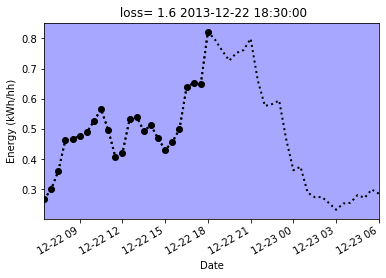

step val 0, {'val_loss': '1.6058422327041626', 'val/kl': '0.5235874056816101', 'val/mse': '0.2528175413608551', 'val/std': '1.0497759580612183'}


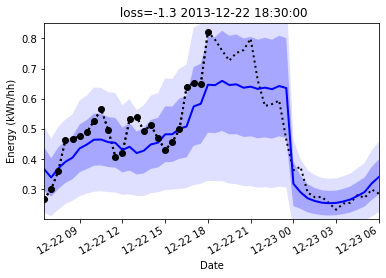

step val 2203, {'val_loss': '-0.8865509629249573', 'val/kl': '1.5426083336933516e-05', 'val/mse': '0.011735223233699799', 'val/std': '0.12130068987607956'}


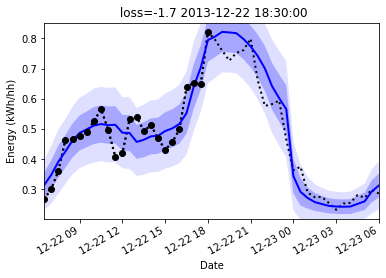

step val 4407, {'val_loss': '-1.328505516052246', 'val/kl': '6.396262506314088e-06', 'val/mse': '0.005052060820162296', 'val/std': '0.06801184266805649'}


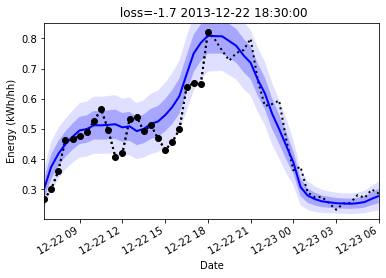

step val 6611, {'val_loss': '-1.3298686742782593', 'val/kl': '2.9036938940407708e-05', 'val/mse': '0.004506400786340237', 'val/std': '0.05295886471867561'}


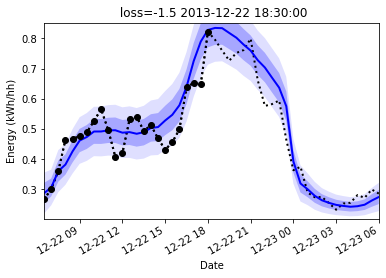

step val 8815, {'val_loss': '-1.1380170583724976', 'val/kl': '2.6329873890063027e-06', 'val/mse': '0.004568228963762522', 'val/std': '0.043883416801691055'}


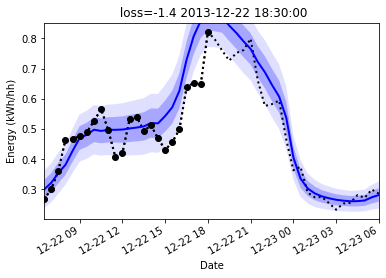

step val 11019, {'val_loss': '-1.1983917951583862', 'val/kl': '8.093993528746068e-06', 'val/mse': '0.0041952296160161495', 'val/std': '0.04045981541275978'}
Epoch     4: reducing learning rate of group 0 to 1.0000e-04.


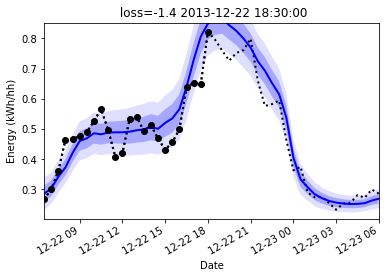

step val 13223, {'val_loss': '-0.6556172966957092', 'val/kl': '5.528800102183595e-06', 'val/mse': '0.004388384986668825', 'val/std': '0.034766603261232376'}


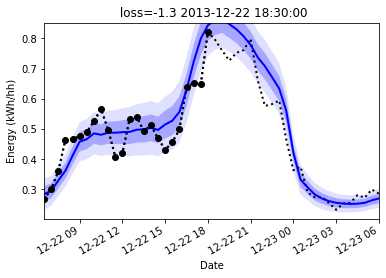

step val 15427, {'val_loss': '-0.5092086791992188', 'val/kl': '4.464794983505271e-06', 'val/mse': '0.00444577494636178', 'val/std': '0.03373691812157631'}
Epoch     6: reducing learning rate of group 0 to 1.0000e-05.


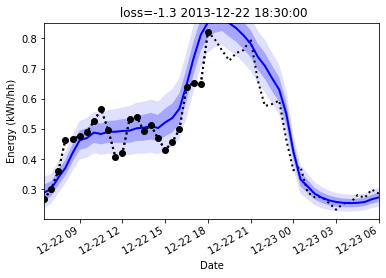

step val 17631, {'val_loss': '-0.48368561267852783', 'val/kl': '3.686278432724066e-06', 'val/mse': '0.004427505657076836', 'val/std': '0.03300008177757263'}


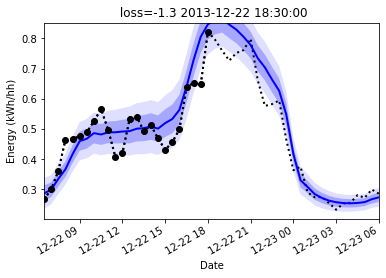

step val 19835, {'val_loss': '-0.4365706145763397', 'val/kl': '3.043319566131686e-06', 'val/mse': '0.004450540523976088', 'val/std': '0.03276505321264267'}
Epoch     8: reducing learning rate of group 0 to 1.0000e-06.


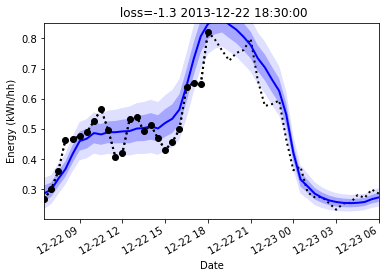

step val 22039, {'val_loss': '-0.4471905827522278', 'val/kl': '3.062065388803603e-06', 'val/mse': '0.004432298708707094', 'val/std': '0.03279681131243706'}


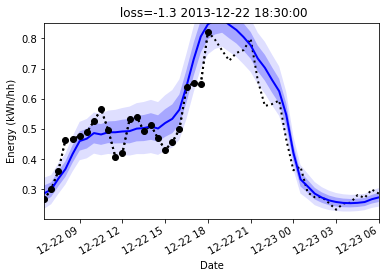

step val 24243, {'val_loss': '-0.44844329357147217', 'val/kl': '3.034672090507229e-06', 'val/mse': '0.004439045209437609', 'val/std': '0.032839469611644745'}
Epoch    10: reducing learning rate of group 0 to 1.0000e-07.


In [ ]:
trainer, model, params, r = try_manual({
    'det_enc_cross_attn_type': 'ptmultihead',
    'det_enc_self_attn_type': 'ptmultihead',
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': True,
    'use_rnn': False,
    'use_lvar': True,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'hidden_dim': 64,
    'learning_rate': 1e-3,
    'latent_dim': 8,
    'n_decoder_layers': 4,
    'n_det_encoder_layers': 4,
    'n_latent_encoder_layers': 4,
}, name='anp-lstm6')

In [ ]:
trainer, model, params, r = try_manual({
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': True,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'hidden_dim': 128,
    'latent_dim': 16,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
}, name='anp-lstm5')

In [ ]:
trainer, model, params, r = try_manual({ 
    'det_enc_cross_attn_type': 'ptmultihead',
    'det_enc_self_attn_type': 'ptmultihead',
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': True,
    'learning_rate': 1e-4,
    'use_rnn': True,
    'use_lvar': True,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
}, name='anp-all')

In [ ]:
trainer, model, params, r = try_manual({
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': True,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'hidden_dim': 64,
    'latent_dim': 8,
}, name='anp-lstm6')

In [ ]:
trainer, model, params, r = try_manual({
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': True,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
}, name='anp-lstm')

In [ ]:
trainer, model, params, r = try_manual({ 
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': False,
    'use_self_attn': False,
    'use_lstm_le': True,
    'use_lstm_d': True,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
}, name='anp-lstm2')

In [ ]:
trainer, model, params, r = try_manual({ 
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': False,
    'use_self_attn': False,
    'use_lstm_le': True,
    'use_lstm_d': True,
    'n_decoder_layers': 4,
    'n_det_encoder_layers': 4,
    'dropout': 0.2,
    'hidden_dim': 128,
    'latent_dim': 16,
}, name='anp-lstmbig')

# Train ANP-RNN

In [ ]:
trainer, model, params, r = try_manual({ 
    'det_enc_cross_attn_type': 'multihead',
    'det_enc_self_attn_type': 'uniform',
    'latent_enc_self_attn_type': 'uniform',
    'use_deterministic_path': True,
    'use_rnn': True
}, name='anp-rnn')

# ANP-RNN 2

In [ ]:
trainer, model, params, r = try_manual({ 
 'use_deterministic_path': False,
 'use_rnn': True,
 'use_lvar': False,
}, name='anp-rnn3')

In [ ]:
# # plot lots of metrics
# loader = model.val_dataloader()[0]
# for i in range(0, len(loader), 10):
#     plot_from_loader(loader, model, i=i)
#     plt.show()

# ANP

In [ ]:
trainer, model, params, r = try_manual({ 
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'multihead',
 'latent_enc_self_attn_type': 'multihead',
 'use_deterministic_path': True,
}, name='anp')

# NP

In [ ]:
trainer, model, params, r = try_manual({ 
 'det_enc_cross_attn_type': 'uniform',
 'det_enc_self_attn_type': 'uniform',
 'latent_enc_self_attn_type': 'uniform',
 'use_deterministic_path': False,
}, name='np')


# Hyperparam

In [ ]:
def objective(trial):
    """Funtion for optuna hyperparam tuning"""
    # see https://github.com/optuna/optuna/blob/cf6f02d/examples/pytorch_lightning_simple.py
    
    trial = add_sugg(trial)
    
#     print('trial', trial.number, 'params', trial.params)
    
    
    # PyTorch Lightning will try to restore model parameters from previous trials if checkpoint
    # filenames match. Therefore, the filenames for each trial must be made unique.
    model, trainer = main(trial, train=True, optuna=True)
    
    # also report to tensorboard & print
    print('logger.metrics', model.logger.metrics[-1:])
    model.logger.experiment.add_hparams(trial.params, model.logger.metrics[-1])
    
    return model.logger.metrics[-1]['val_loss']


In [ ]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args(['-p'])

# pruner = optuna.pruners.MedianPruner(n_warmup_steps=1, n_startup_trials=20) if args.pruning else optuna.pruners.NopPruner()
pruner = optuna.pruners.PercentilePruner(75.0)
name = 'anp-rnn1'
study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name=name, load_if_exists=True)
study.user_attrs = user_attrs


In [ ]:
study.optimize(objective, n_trials=200, timeout=pd.Timedelta('3d').total_seconds())

In [ ]:

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# shutil.rmtree(MODEL_DIR)

## View

TODO

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

In [ ]:
df.sort_values('value').head(17).T